In [55]:
# For reading data sets from the web.
import pandas
# For lots of great things.
import numpy as np
# To make our plots.
import matplotlib.pyplot as plt
%matplotlib inline
# Because sympy and LaTeX make
# everything look wonderful!
from sympy import *
init_printing(use_latex=True)
from IPython.display import display
# We will use this to check our implementation...
from sklearn.decomposition import PCA
# We will grab another data set using Keras
# after we finish up with Iris...
import keras
# Need this for LabelEncoder
from sklearn import preprocessing

In [56]:
student_data = np.array(pandas.read_table("./student-por.csv",
delimiter=";", header=0))

In [57]:
student_data.shape

In [58]:
le = preprocessing.LabelEncoder()

# Encoding non-numeric data to integers

In [59]:
# School (binomial)
le.fit(student_data[:,0])
student_data[:,0] = le.transform(student_data[:,0])

In [60]:
# Sex (binomial)
le.fit(student_data[:,1])
student_data[:,1] = le.transform(student_data[:,1])

In [61]:
# address (binomial)
le.fit(student_data[:,3])
student_data[:,3] = le.transform(student_data[:,3])

In [62]:
# Famsize (binomial)
le.fit(student_data[:,4])
student_data[:,4] = le.transform(student_data[:,4])

In [63]:
# Pstatus (binomial)
le.fit(student_data[:,5])
student_data[:,5] = le.transform(student_data[:,5])

In [64]:
# Mjob (nominal)
le.fit(student_data[:,8])
student_data[:,8] = le.transform(student_data[:,8])

In [65]:
# Fjob (nominal)
le.fit(student_data[:,9])
student_data[:,9] = le.transform(student_data[:,9])

In [66]:
# Reason (nominal)
le.fit(student_data[:,10])
student_data[:,10] = le.transform(student_data[:,10])

In [67]:
# Guardian (nominal)
le.fit(student_data[:,11])
student_data[:,11] = le.transform(student_data[:,11])

In [68]:
# schoolsup (binomial)
le.fit(student_data[:,15])
student_data[:,15] = le.transform(student_data[:,15])

In [69]:
# famsup (binomial)
le.fit(student_data[:,16])
student_data[:,16] = le.transform(student_data[:,16])

In [70]:
# paid (binomial)
le.fit(student_data[:,17])
student_data[:,17] = le.transform(student_data[:,17])

In [71]:
# activities (binomial)
le.fit(student_data[:,18])
student_data[:,18] = le.transform(student_data[:,18])

In [72]:
# nursery (binomial)
le.fit(student_data[:,19])
student_data[:,19] = le.transform(student_data[:,19])

In [73]:
# higher (binomial)
le.fit(student_data[:,20])
student_data[:,20] = le.transform(student_data[:,20])

In [74]:
# internet (binomial)
le.fit(student_data[:,21])
student_data[:,21] = le.transform(student_data[:,21])

In [75]:
# romantic (binomial)
le.fit(student_data[:,22])
student_data[:,22] = le.transform(student_data[:,22])

In [76]:
student_data

array([[0, 0, 18, ..., 0, 11, 11],
       [0, 0, 17, ..., 9, 11, 11],
       [0, 0, 15, ..., 12, 13, 12],
       ...,
       [1, 0, 18, ..., 11, 12, 9],
       [1, 1, 17, ..., 10, 10, 10],
       [1, 1, 18, ..., 10, 11, 11]], dtype=object)

# Encoding 0's to -1 for binomial data.

### Surely there's a one line method to do this... right, Keras?

In [77]:
school = student_data[:,0]
school = np.where(school==0, -1, school)
student_data[:,0] = school

In [78]:
sex = student_data[:,1]
sex = np.where(sex==0, -1, sex)
student_data[:,1] = sex

In [79]:
address = student_data[:,3]
address = np.where(address==0, -1, address)
student_data[:,3] = address

In [80]:
famsize = student_data[:,4]
famsize = np.where(famsize==0, -1, famsize)
student_data[:,4] = famsize

In [81]:
Pstatus = student_data[:,5]
Pstatus = np.where(Pstatus==0, -1, Pstatus)
student_data[:,5] = Pstatus

In [82]:
schoolsup = student_data[:,15]
schoolsup = np.where(schoolsup==0, -1, schoolsup)
student_data[:,15] = schoolsup

In [83]:
famsup = student_data[:,16]
famsup = np.where(famsup==0, -1, famsup)
student_data[:,16] = famsup

In [84]:
paid = student_data[:,17]
paid = np.where(paid==0, -1, paid)
student_data[:,17] = paid

In [85]:
activities = student_data[:,18]
activities = np.where(activities==0, -1, activities)
student_data[:,18] = activities

In [86]:
nursery = student_data[:,19]
nursery = np.where(nursery==0, -1, nursery)
student_data[:,19] = nursery

In [87]:
higher = student_data[:,20]
higher = np.where(higher==0, -1, higher)
student_data[:,20] = higher

In [88]:
internet = student_data[:,21]
internet = np.where(internet==0, -1, internet)
student_data[:,21] = internet

In [89]:
romantic = student_data[:,22]
romantic = np.where(romantic==0, -1, romantic)
student_data[:,22] = romantic

# Standardizing the nominal and numerical data.

In [90]:
scaler = preprocessing.StandardScaler()

### I don't think this warning is THAT concerning

In [91]:
temp = student_data[:,[2,6,7,8,9,10,11,12,13,14,23,24,25,26,27,28,29,30,31]]
Standardized = scaler.fit_transform(temp)

/nfshome/apps/python-3.6.7/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/nfshome/apps/python-3.6.7/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Not sure about the -0.0 for the mean...

In [92]:
print('Mean:', round(Standardized.mean()))
print('Standard deviation:', Standardized.std())

Mean: -0.0
Standard deviation: 1.0


In [93]:
student_data[:,[2,6,7,8,9,10,11,12,13,14,23,24,25,26,27,28,29,30,31]] = Standardized

In [94]:
x = student_data[:,0:32]

In [95]:
x[0,0:]

array([-1, -1, 1.0316951635937113, 1, -1, -1, 1.310215632680141,
       1.5407154371084224, -1.556452535644832, 2.057247821444129,
       -0.9339740507872134, 0.3326475069742609, 0.5767179914572501,
       0.08365294968062233, -0.3743051181921297, 1, -1, -1, -1, 1, 1, -1,
       -1, 0.07260614867809903, -0.17164653548813819, 0.6937849605682166,
       -0.5435553304269218, -0.9976946599159401, -0.3710421971530383,
       0.0734333641512146, -4.155470294933876, -0.1958196099225682],
      dtype=object)

In [96]:
results = student_data[:,32] # output vector

### Convert results to one-hot encoding
#### the actual output vector doesn't include at least one example of each possible grade so I made a vector of all possibilities for to_categorical

In [97]:
possible_results = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]

In [98]:
y = keras.utils.to_categorical(results, len(possible_results))

# Data is now preprocessed

### Note: columns 31 and 32 are not used. I do not believe they are useful for our net.

In [99]:
model = keras.Sequential()

In [100]:
input_size = x.shape[1]
output_size = y.shape[1]

In [101]:
# create the hidden layer
model.add(keras.layers.Dense(400,input_dim=input_size,activation='relu'))

In [102]:
model.add(keras.layers.Dense(200,activation='relu'))

In [103]:
# output layer
model.add(keras.layers.Dense(output_size,activation='softmax'))

In [104]:
# compile
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [105]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 400)               13200     
_________________________________________________________________
dense_5 (Dense)              (None, 200)               80200     
_________________________________________________________________
dense_6 (Dense)              (None, 20)                4020      
Total params: 97,420
Trainable params: 97,420
Non-trainable params: 0
_________________________________________________________________


# Model Training
## This is some results from training the model
## Loss seems to be going down slowly
## Interestingly val_loss seems to be increasing 
## I have ploted the loss below
## I could not plot accuracy which is weird and I will have to look into what is causing that
# Austin

In [106]:
history = model.fit(x,y,batch_size = 32, epochs = 160, verbose = 0, validation_split = 0.25)

In [107]:
score = model.evaluate(x,y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.378753764534768
Test accuracy: 0.807395993859632


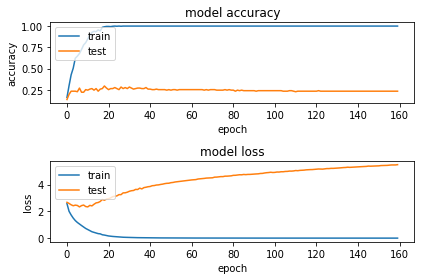

In [108]:
plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

In [113]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.378753764534768
Test accuracy: 0.807395993859632


In [109]:
## PCAs of Data

In [110]:
#def func(X):
 #   return X
#xFunc = np.apply_along_axis(func,0,x)


#U,S,V = np.linalg.svd(xFunc,full_matrices=True)

# Plot the percent of variance accounted for by each feature
#plt.plot(100.0*S/np.sum(S))
#plt.ylabel("Percent Variance")
#plt.xlabel("Singular Value")
#plt.show()

In [111]:
pca=PCA()
pca.fit(x)
pca_data = pca.transform(x)

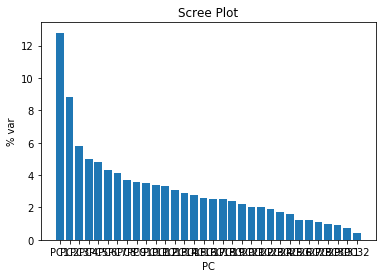

In [112]:
per_var = np.round(pca.explained_variance_ratio_* 100, decimals = 1)
labels = ['PC' + str(i) for i in range (1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel("% var")
plt.xlabel("PC")
plt.title("Scree Plot")
plt.show()